In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import cm
import os
import glob
import math
import time
import pyart
import singledop
import xray
from cmap_map import lighten_cmap
%matplotlib inline

In [2]:
sd_test = singledop.SingleDoppler2D(range_limits=[10,100], azimuth_limits=[180,360], 
                                    L=60.0, U=20.0, V=1.0, noise=True)

8100 total observations (M)


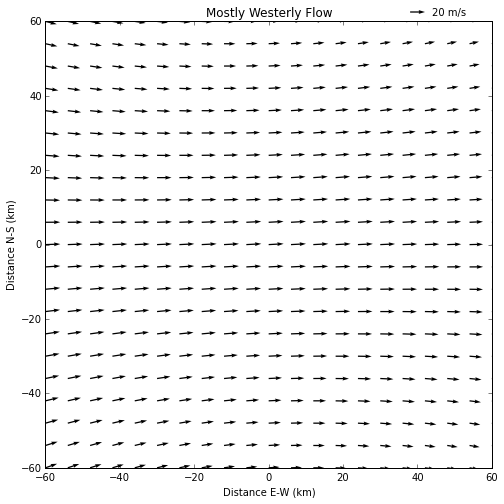

In [3]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
display = singledop.AnalysisDisplay(sd_test)
display.plot_velocity_vectors(title='Mostly Westerly Flow', thin=6, scale=600, legend=20)

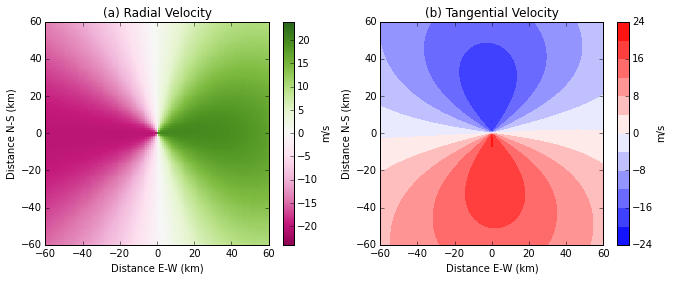

In [4]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
display.plot_velocity_contours('vr', cmap='PiYG', title='(a) Radial Velocity', mesh_flag=True)
ax2 = fig.add_subplot(122)
display.plot_velocity_contours('vt', title='(b) Tangential Velocity')

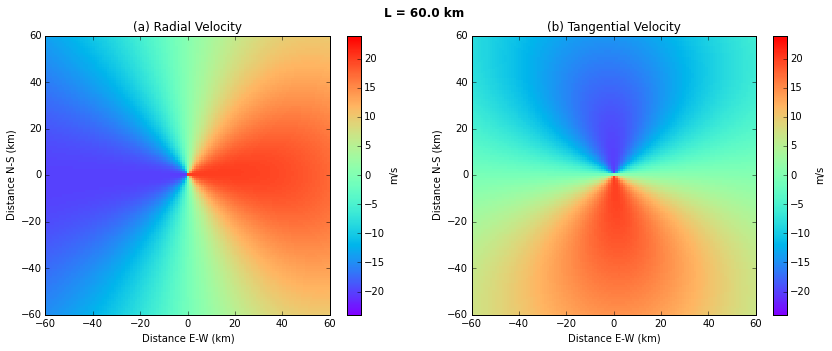

In [5]:
display.plot_radial_tangential_contours(mesh_flag=True, cmap='rainbow')

###xray testing

In [6]:
print(sd_test.grid_limits)
print(sd_test.analysis_x.shape)
print(sd_test.analysis_y.shape)
print(sd_test.analysis_vr.shape)
print(sd_test.analysis_vt.shape)
if not hasattr(sd_test, 'analysis_u'):
    sd_test.get_velocity_vectors()
print(sd_test.analysis_u.shape)
print(sd_test.analysis_v.shape)
print(sd_test.L)

[-60.0, 60.0]
(121, 121)
(121, 121)
(121, 121)
(121, 121)
(121, 121)
(121, 121)
60.0


In [7]:
save = singledop.SaveFile(SingleDoppler2D=sd_test, filename='data.dat')

Initializing singledop.SaveFile object
Writing to ./data.dat


In [8]:
print(sd_test.radar)

None


In [9]:
os.system('rm file*.nc')
sd = singledop.NetcdfSave(sd_test, 'file.nc')

In [11]:
sd = singledop.NetcdfSave('file.nc')
print(sd.analysis.analysis_u)

[[ 15.63056564  15.60054874  15.57071018 ...,  12.1574831   12.054739
   11.94992065]
 [ 15.7567873   15.72744274  15.69826508 ...,  12.31982136  12.21647263
   12.11100769]
 [ 15.88229275  15.85361862  15.82509804 ...,  12.48128223  12.37733746
   12.27123356]
 ..., 
 [ 15.47017002  15.44699001  15.42415619 ...,  11.62797832  11.52451897
   11.41925335]
 [ 15.34304905  15.31901646  15.29532909 ...,  11.4791317   11.37651634
   11.27212334]
 [ 15.21517086  15.19028473  15.16574192 ...,  11.33078194  11.22901726
   11.12550354]]


In [12]:
save = singledop.NetcdfSave(sd, 'file.nc')

In [13]:
da1 = xray.DataArray(sd.analysis_u, dims=['x', 'y'],
                     attrs={'name': 'eastward component of wind', 
                            'units': 'meters per second'})
da2 = xray.DataArray(sd.analysis_v, dims=['x', 'y'],
                     attrs={'name': 'northward component of wind',
                            'units': 'meters per second'})
ds = xray.Dataset({'analysis_u': da1, 'analysis_v': da2})
ds.to_netcdf('test.nc')

In [14]:
display = singledop.AnalysisDisplay(sd.analysis)

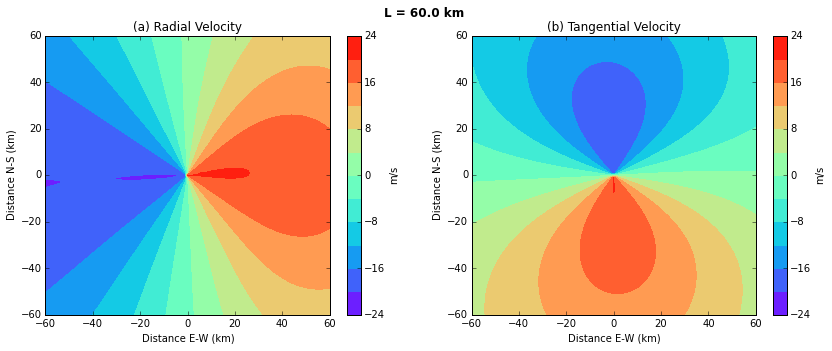

In [15]:
display.plot_radial_tangential_contours(mesh_flag=False, cmap='rainbow', save='test_save.png')

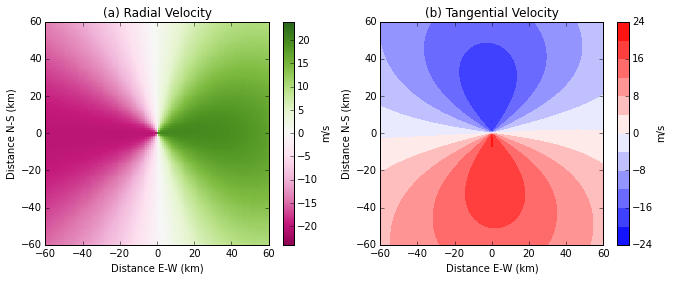

In [16]:
fig = plt.figure(figsize=(11,4))
ax1 = fig.add_subplot(121)
display.plot_velocity_contours('vr', cmap='PiYG', title='(a) Radial Velocity', mesh_flag=True)
ax2 = fig.add_subplot(122)
display.plot_velocity_contours('vt', title='(b) Tangential Velocity')

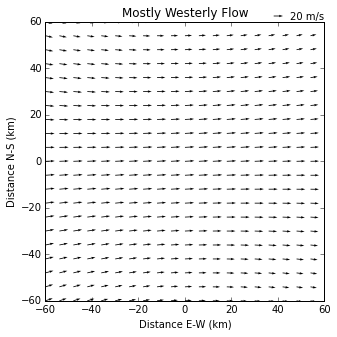

In [17]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
display.plot_velocity_vectors(title='Mostly Westerly Flow',
                              thin=6, scale=600, legend=20)

In [18]:
display.four_panel_plot()

Missing radar object, try again


In [19]:
from matplotlib import cm
cmap = cm.get_cmap('pyart_LangRainbow12')
lcmap = lighten_cmap(cmap)

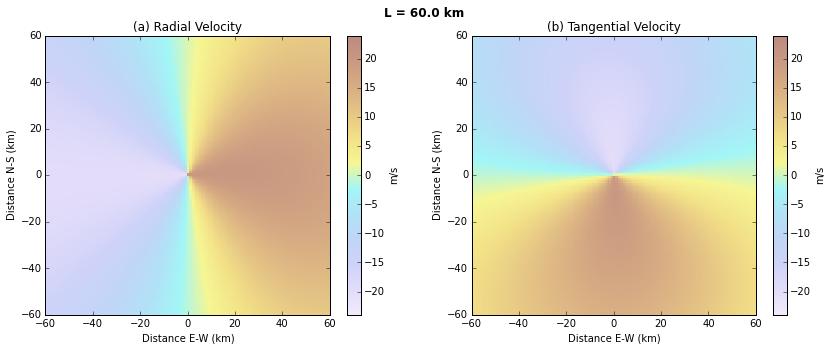

In [20]:
display.plot_radial_tangential_contours(mesh_flag=True, cmap=lcmap, save='test_save.png')

### Xu et al. (2006) Figure 4

In [21]:
gs = 121
xgrid = np.arange(gs)-60.0 
ygrid = np.arange(gs)-60.0
x, y = np.meshgrid(xgrid, ygrid)
cond = y > 0.75 * x + 30

Uin = 0.0 + np.zeros((gs,gs), dtype='float')
Vin = 20.0 + np.zeros((gs,gs), dtype='float')
Uin[cond] = 15.0
Vin[cond] = -15.0

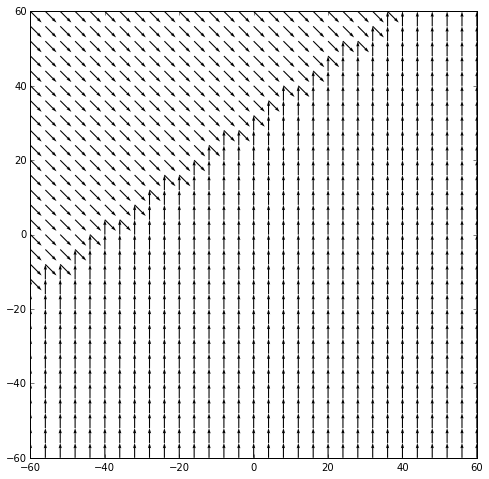

In [22]:
fig = plt.figure(figsize=(8,8))
cond = np.logical_and(x % 4 == 0, y % 4 == 0)
ax = fig.add_subplot(111)
ax.quiver(x[cond], y[cond], Uin[cond], Vin[cond], scale=600)

In [23]:
sd_test2 = singledop.SingleDoppler2D(range_limits=[0,90], azimuth_limits=[0,360], 
                                     L=30.0, xgrid=np.arange(gs)-60.0, noise=True,
                                     ygrid=np.arange(gs)-60.0, U=Uin, V=Vin)

14641 total observations (M)


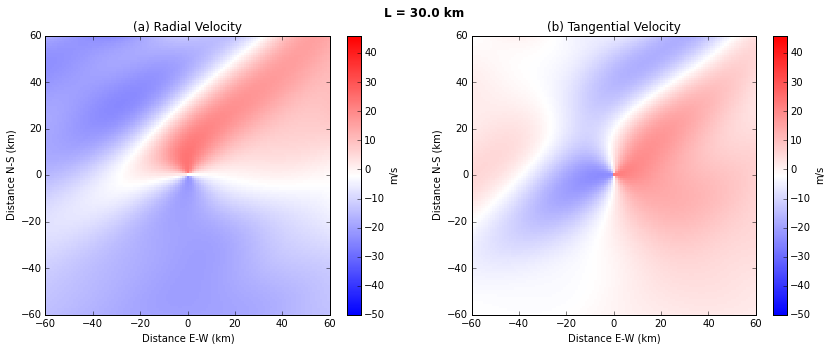

In [26]:
display = singledop.AnalysisDisplay(sd_test2)
display.plot_radial_tangential_contours(levels=-50.0+4.0*np.arange(25), mesh_flag=True)

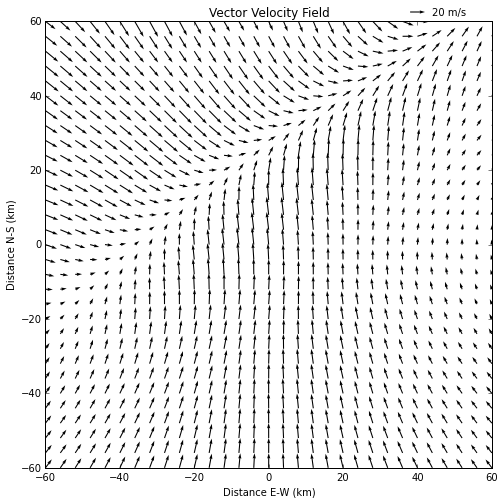

In [27]:
fig = plt.figure(figsize=(8,8))
display.plot_velocity_vectors(legend=20)

### Real Radar Data Test

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import pyart
import singledop
import os
import glob
import time
%matplotlib inline

In [32]:
fdir = '/Users/tjlang/Documents/OVWST/SingleDop/TestData/'
files = sorted(glob.glob(fdir+'*.nc'))
print(files)
iii = 1
print(os.path.basename(files[iii]))
radar = pyart.io.read(files[iii])

['/Users/tjlang/Documents/OVWST/SingleDop/TestData/cfrad.20111124_113017.000_to_20111124_113753.000_toga_v0_SUR.nc', '/Users/tjlang/Documents/OVWST/SingleDop/TestData/cfrad.20111125_043019.000_to_20111125_043754.000_toga_v0_SUR.nc', '/Users/tjlang/Documents/OVWST/SingleDop/TestData/cfrad.20111127_180012.000_to_20111127_180832.000_toga_v0_SUR.nc']
cfrad.20111125_043019.000_to_20111125_043754.000_toga_v0_SUR.nc


In [34]:
print(radar.time['units'][14:])

2011-11-25T04:30:19Z


In [35]:
radar.fields.keys()

dict_keys(['AZ', 'VE', 'CH', 'SW', 'SQ', 'VR', 'DZ', 'CZ', 'AH'])

In [37]:
print(radar.latitude['data'][0], radar.longitude['data'][0])

0.124166667461 80.5855560303


In [38]:
sd_test = singledop.SingleDoppler2D(L=30.0, radar=radar, range_limits=[0, 100],
                                    sweep_number=0, name_vr='VE', thin_factor=[2, 8])

15109 total observations (M)


/Users/tjlang/anaconda/envs/python3/lib/python3.4/site-packages/pyart/graph/radardisplay.py:122: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn('RadarDisplay does not correct for moving platforms')


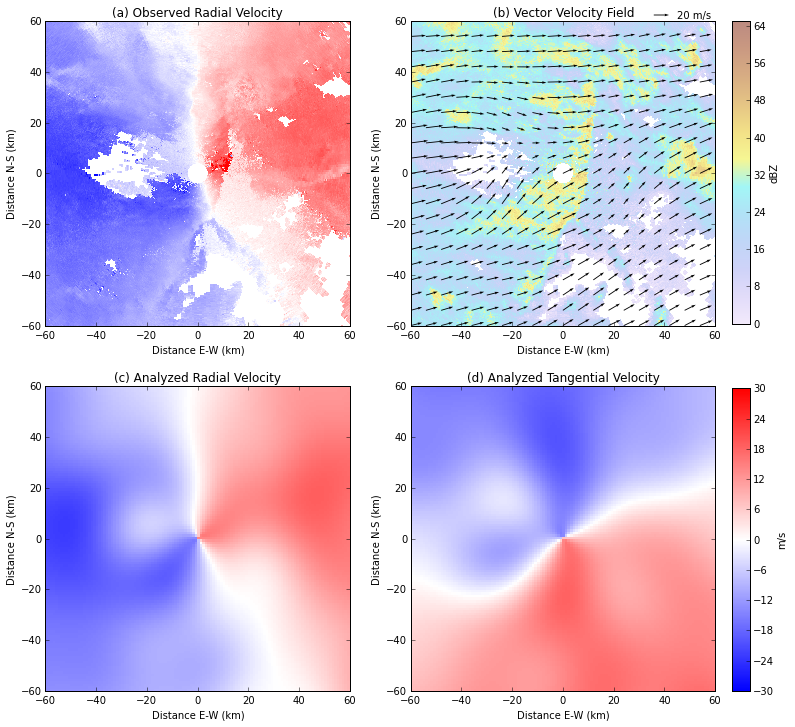

In [39]:
display = singledop.AnalysisDisplay(sd_test)
display.four_panel_plot(scale=400, legend=20, return_flag=False, thin=6, 
                        levels=-30.0+2.0*np.arange(31), name_vr='VE', name_dz='AZ',
                        save='singledop_4panel_test.png')

In [41]:
cond = np.logical_and(sd_test.analysis_x == 0, sd_test.analysis_y == 0)
print(sd_test.analysis_u[cond], sd_test.analysis_v[cond])
print(270.0 - np.rad2deg(math.atan2(sd_test.analysis_v[cond], sd_test.analysis_u[cond])))
print((sd_test.analysis_u[cond]**2 + sd_test.analysis_v[cond]**2)**0.5)

[ 14.13032938] [ 6.8520537]
244.130409781
[ 15.70403924]


### Saving to file

In [42]:
save = singledop.NetcdfSave(sd_test, 'test.nc', radar=radar)

In [43]:
save = singledop.NetcdfSave('test.nc', radar=files[iii])

In [47]:
print(save.radar.time)

{'units': 'seconds since 2011-11-25T04:30:19Z', 'long_name': 'time in seconds since volume start', 'standard_name': 'time', 'comment': 'times are relative to the volume start_time', 'calendar': 'gregorian', 'data': array([  0.00000000e+00,   5.55555820e-02,   1.11111164e-01, ...,
         4.54882353e+02,   4.54941176e+02,   4.55000000e+02])}


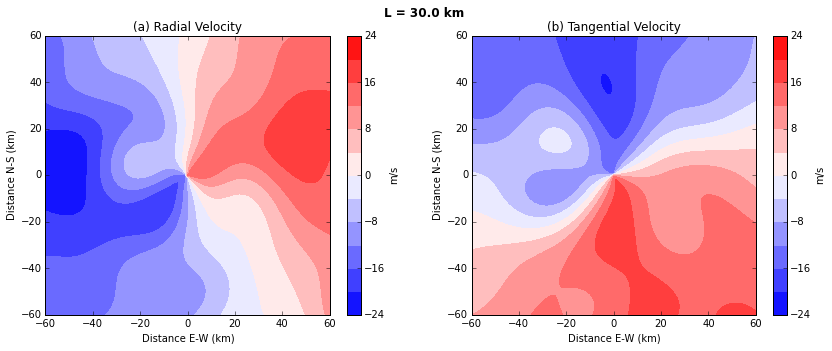

In [48]:
display = singledop.AnalysisDisplay(save)
display.plot_radial_tangential_contours()

/Users/tjlang/anaconda/envs/python3/lib/python3.4/site-packages/pyart/graph/radardisplay.py:122: UserWarning: RadarDisplay does not correct for moving platforms
  warnings.warn('RadarDisplay does not correct for moving platforms')


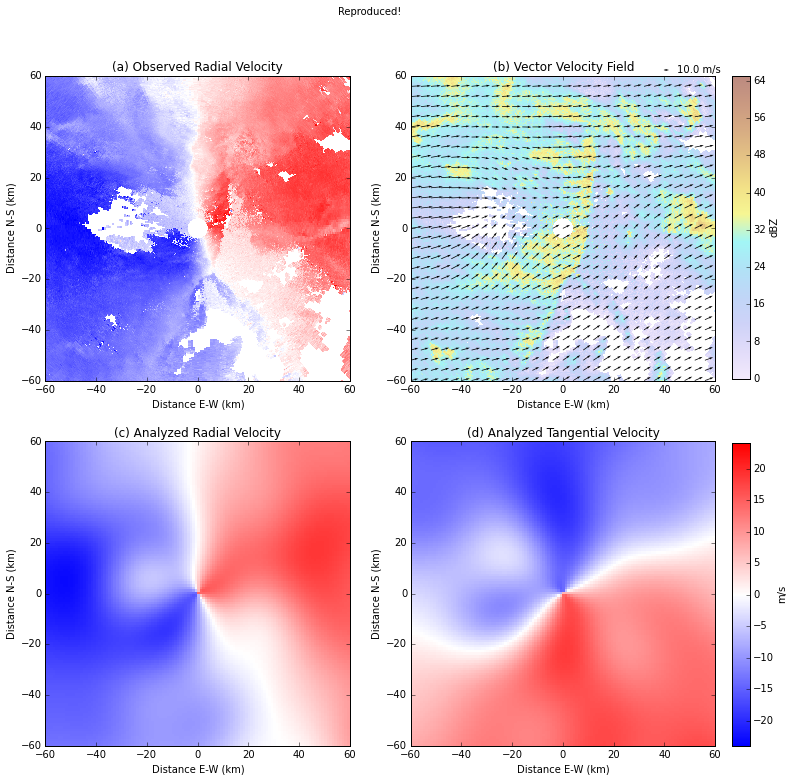

In [49]:
fig, ax1, ax2, ax3, ax4 = display.four_panel_plot(name_vr='VE', name_dz='AZ', 
                                                  return_flag=True)
fig.suptitle('Reproduced!')